<a href="https://colab.research.google.com/github/Oaybarf/FX/blob/main/GITHUB_Estrategia_USDPEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuración e Instalaciones

In [1]:
%%capture
# Instalar otros paquetes
!pip install tabulate
!pip install statsmodels


url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

# Corrida Completa
  Candlestick patterns, Relative Strength Index (RSI), Bollinger Bands, and Moving Average Convergence Divergence (MACD).

## Descargando Información y Calculando Indicadores

### Importaciones

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import talib as ta
from talib import MA_Type
from tabulate import tabulate
import matplotlib.pyplot as plt
import datetime as dt
import plotly.io as pio
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
import smtplib
from datetime import datetime

### Download Data

In [3]:
stock_symbol = 'PEN=X' # USD
# stock_symbol = 'VSAT' # VIASAT

stock_data = yf.download(stock_symbol,  period="max")

# Create a Date column
stock_data['Date'] = stock_data.index
# Drop the Date as index
stock_data.reset_index(drop=True, inplace=True)

fecha_hora_actual = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Fecha y Hora Actual: {fecha_hora_actual}")

[*********************100%***********************]  1 of 1 completed

Fecha y Hora Actual: 2024-10-01 22:47:02


### Clean Data

In [4]:
dt_all = pd.date_range(start=stock_data.index[0],end=stock_data.index[-1])

dt_obs = [d.strftime("%Y-%m-%d") for d in pd.to_datetime(stock_data.index)]

dt_breaks = [d for d in dt_all.strftime("%Y-%m-%d").tolist() if not d in dt_obs]

### Cálculos Indicadores Técnicos

In [5]:
# 1. EMA 10, 20, 50
# --------------------------------------------
stock_data['EMA10'] = stock_data['Close'].ewm(span=10, min_periods=10, adjust=False).mean()
stock_data['EMA20'] = stock_data['Close'].ewm(span=20, min_periods=20, adjust=False).mean()
stock_data['EMA50'] = stock_data['Close'].ewm(span=50, min_periods=50, adjust=False).mean()
stock_data['EMA100'] = stock_data['Close'].ewm(span=100, min_periods=100, adjust=False).mean()
stock_data['EMA200'] = stock_data['Close'].ewm(span=200, min_periods=200, adjust=False).mean()

# 2. MACD values
# --------------------------------------------
stock_data['macd'], stock_data['macdSignal'], stock_data['macdHist'] = ta.MACD(stock_data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
stock_data['macddiff1'] = stock_data['macd'].shift(1) - stock_data['macdSignal'].shift(1)
stock_data['macddiff-1'] = stock_data['macd'].shift(-1) - stock_data['macdSignal'].shift(-1)

# 3. RSI
# --------------------------------------------
stock_data['RSI'] = ta.RSI(stock_data.Close, 14)


# 4. Bollinger Bands
# --------------------------------------------
stock_data['BU'], stock_data['BM'], stock_data['BL'] = ta.BBANDS(stock_data.Close,
                                                                 timeperiod=20,
                                                                 matype=MA_Type.EMA)
# 5. Buy and Sell Signals
# --------------------------------------------
# Drop Buy and Sell columns if they exist
stock_data.drop(['Buy', 'Sell'], inplace=True, axis=1, errors='ignore')

# Create DataFrame
df_buy = stock_data.query('Low < BL')[['Date', 'Close']]
df_sell = stock_data.query('High > BU')[['Date', 'Close']]

# Round close values for both buy and sell
# df_buy['Close'] = round(df_buy.Close.round())
# df_sell['Close'] = round(df_sell.Close.round())

# 5. ATR
# --------------------------------------------
stock_data['ATR'] = ta.ATR(stock_data['High'], stock_data['Low'], stock_data['Close'], timeperiod=14)
stock_data['ATR_SMA_1year'] = stock_data['ATR'].rolling(window=252).mean()

### Recomendaciones

In [6]:
stock_data['EMA10_Recommendation'] = 0
stock_data['EMA20_Recommendation'] = 0
stock_data['EMA50_Recommendation'] = 0
stock_data['EMA100_Recommendation'] = 0
stock_data['EMA200_Recommendation'] = 0
stock_data['MACD_Recommendation'] = 0
stock_data['RSI_Recommendation'] = 0
stock_data['BB_Recommendation'] = 0
stock_data['ATR_Recommendation'] = 0
stock_data['Final_Recommendation'] = 0


stock_data.loc[stock_data['RSI'] > 70, 'RSI_Recommendation'] = -1  # Venta para RSI sobrecomprado
stock_data.loc[stock_data['RSI'] < 30, 'RSI_Recommendation'] = 1   # Compra para RSI sobrevendido

stock_data.loc[stock_data['Close'] > stock_data['BU'], 'BB_Recommendation'] = -1  # Venta para precios por encima de la banda superior de Bollinger
stock_data.loc[stock_data['Close'] < stock_data['BL'], 'BB_Recommendation'] = 1   # Compra para precios por debajo de la banda inferior de Bollinger

# Recomendación de compra cuando la diferencia cruza de negativa a positiva (cruce hacia arriba)
stock_data.loc[(stock_data['macd'] > stock_data['macdSignal']) & (stock_data['macd'].shift(1) <= stock_data['macdSignal'].shift(1)), 'MACD_Recommendation'] = -1
stock_data.loc[(stock_data['macd'] < stock_data['macdSignal']) & (stock_data['macd'].shift(1) >= stock_data['macdSignal'].shift(1)), 'MACD_Recommendation'] = 1


emas = ['EMA10', 'EMA20', 'EMA50', 'EMA100', 'EMA200']
for ema in emas:
    stock_data.loc[(stock_data[ema] > stock_data['Close']) & (stock_data[ema].shift(1) <= stock_data['Close'].shift(1)), f'{ema}_Recommendation'] = 1
    stock_data.loc[(stock_data[ema] < stock_data['Close']) & (stock_data[ema].shift(1) >= stock_data['Close'].shift(1)), f'{ema}_Recommendation'] = -1


stock_data.loc[(stock_data['ATR'] > stock_data['ATR_SMA_1year']) & (stock_data['ATR'].shift(1) <= stock_data['ATR_SMA_1year'].shift(1)), 'ATR_Recommendation'] = 1
stock_data.loc[(stock_data['ATR'] < stock_data['ATR_SMA_1year']) & (stock_data['ATR'].shift(1) >= stock_data['ATR_SMA_1year'].shift(1)), 'ATR_Recommendation'] = -1


stock_data['Promedio_Recomendaciones'] = (stock_data['EMA10_Recommendation'] * 0.10 +
                                          stock_data['EMA20_Recommendation'] * 0.10 +
                                          stock_data['EMA50_Recommendation'] * 0.10 +
                                          stock_data['MACD_Recommendation'] * 0.20 +
                                          stock_data['RSI_Recommendation'] * 0.25 +
                                          stock_data['BB_Recommendation'] * 0.25)

stock_data['Final_Recommendation'] = round(stock_data['Promedio_Recomendaciones'])+0.0

### BackTesting

In [7]:
# Calcular el cambio en el precio del siguiente mes
stock_data['Next_Month_Close'] = stock_data['Close'].shift(-20)  # Suponiendo que cada mes tiene 20 días hábiles

# Calcular el cambio en el precio
stock_data['Price_Change'] = (stock_data['Next_Month_Close'] / stock_data['Close'] -1)

# Calcular la rentabilidad de cada estrategia
strategies = ['EMA10_Recommendation', 'EMA20_Recommendation', 'EMA50_Recommendation', 'EMA100_Recommendation', 'EMA200_Recommendation',
              'MACD_Recommendation', 'RSI_Recommendation', 'BB_Recommendation', 'ATR_Recommendation','Final_Recommendation']

for strategy in strategies:
    stock_data[strategy + '_Profit'] = stock_data[strategy] * stock_data['Price_Change']


In [8]:
# Inicializar un diccionario para almacenar los resultados por estrategia
summary_by_year = {}

# Iterar sobre cada año
for year in stock_data['Date'].dt.year.unique():
    # Filtrar los datos para el año actual y eliminar las rentabilidades iguales a 0
    year_data = stock_data[stock_data['Date'].dt.year == year]

    # Inicializar un diccionario para almacenar las rentabilidades medias por estrategia
    yearly_mean_profit = {}

    # Calcular la media de todas las rentabilidades para el año actual por cada estrategia
    for strategy in strategies:
        yearly_mean_profit[strategy + '_Profit'] = year_data[year_data[strategy + '_Profit'] != 0][strategy + '_Profit'].count()

    # Agregar los resultados al diccionario
    summary_by_year[year] = yearly_mean_profit

# Crear un DataFrame a partir del diccionario
summary_df = pd.DataFrame(summary_by_year).transpose()

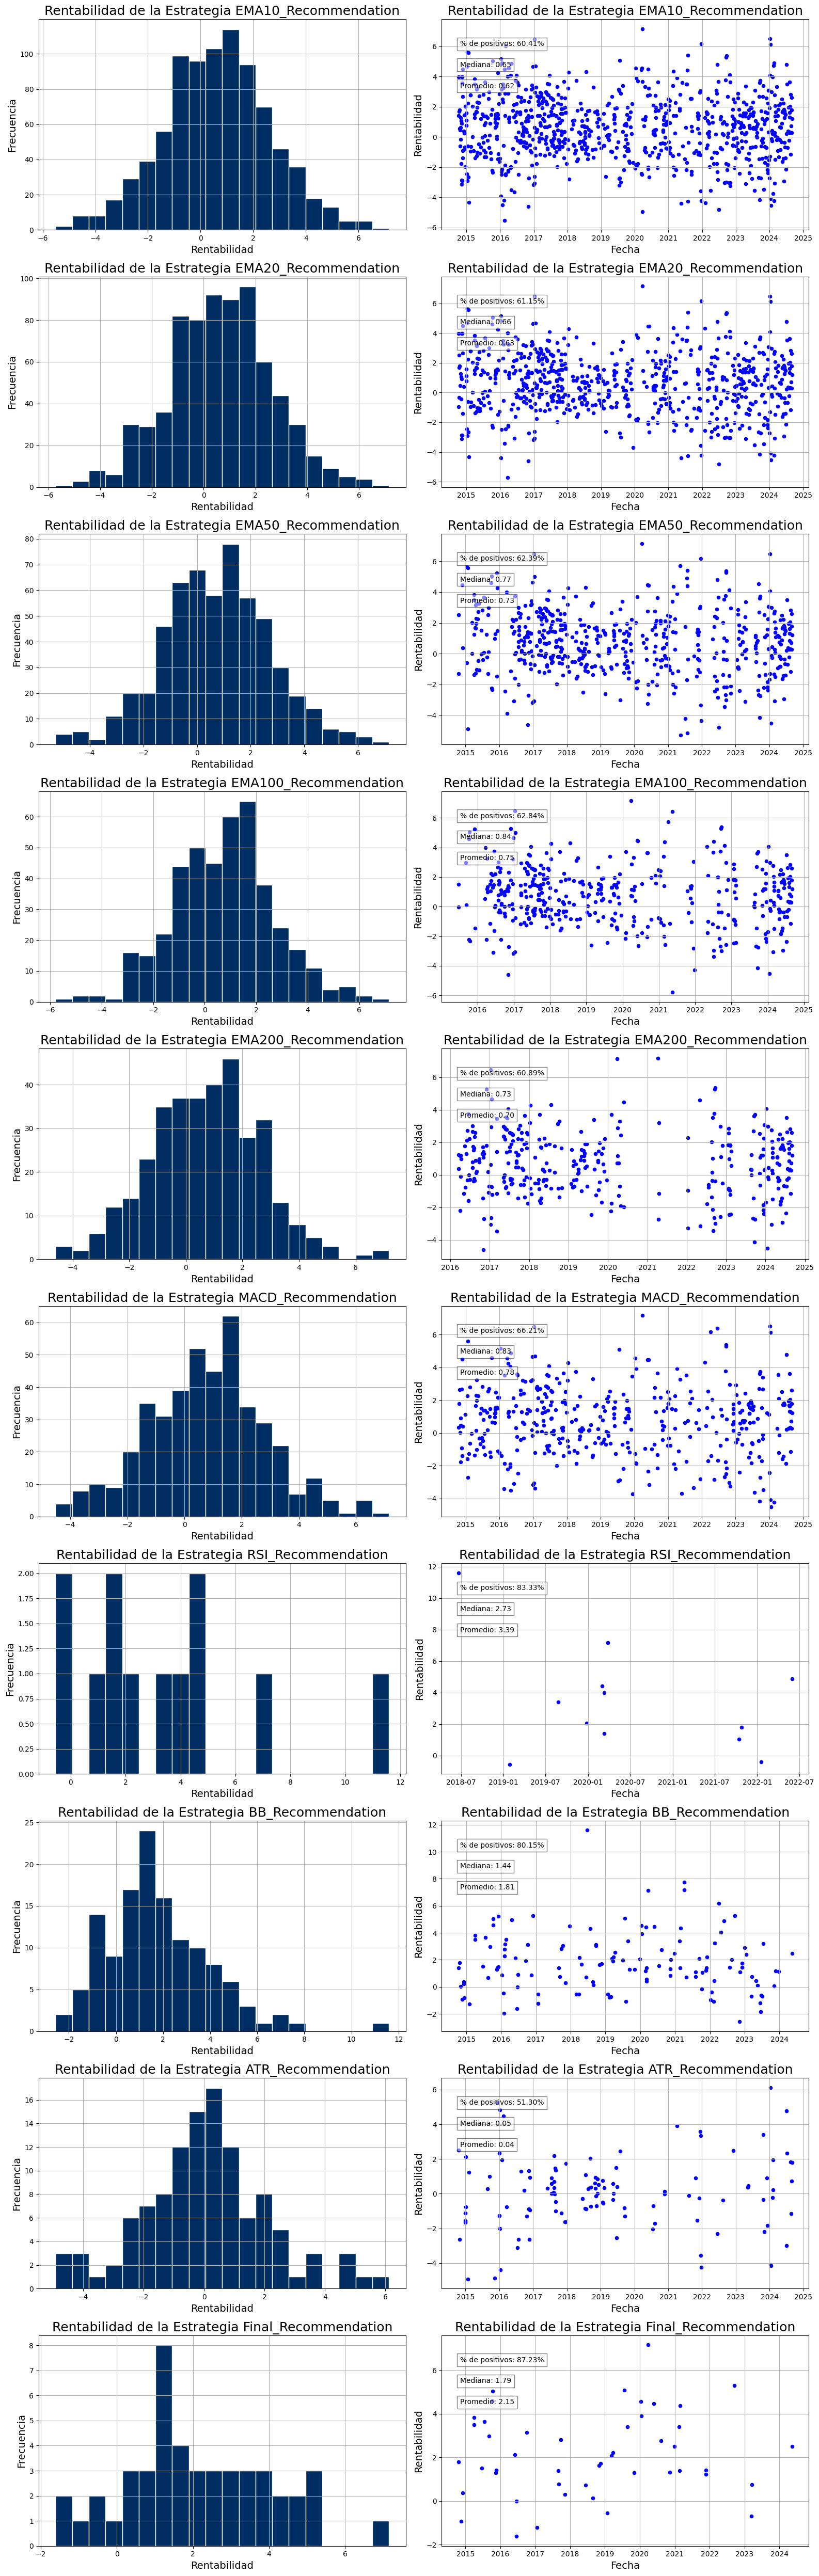

In [9]:
# Crear subplots con histogramas y gráficos de líneas
plt.style.use('default')
fig, axs = plt.subplots(len(strategies), 2, figsize=(16, 5*len(strategies)))
years_ago = dt.datetime.now() - dt.timedelta(days=10*365)
color_is = (0, 0.176, 0.384)

for i, strategy in enumerate(strategies):
    # Filtrar las filas donde la recomendación no sea aproximadamente 0
    filtered_data = stock_data[(stock_data[strategy] != 0) & (stock_data['Date'] > years_ago)]

    # Histograma
    axs[i, 0].hist(filtered_data[strategy + '_Profit'] * 100, bins=20, color=color_is, edgecolor='white')
    axs[i, 0].set_title(f'Rentabilidad de la Estrategia {strategy}', fontsize=18)
    axs[i, 0].set_xlabel('Rentabilidad', fontsize=14)
    axs[i, 0].set_ylabel('Frecuencia', fontsize=14)
    axs[i, 0].grid(True)

    # Gráfico de puntos
    axs[i, 1].scatter(filtered_data['Date'], filtered_data[strategy + '_Profit'] * 100, color='blue', s=20)
    axs[i, 1].set_title(f'Rentabilidad de la Estrategia {strategy}', fontsize=18)
    axs[i, 1].set_xlabel('Fecha', fontsize=14)
    axs[i, 1].set_ylabel('Rentabilidad', fontsize=14)
    axs[i, 1].grid(True)

    # Calcular el porcentaje de rentabilidades positivas
    positive_percentage = (filtered_data[strategy + '_Profit'] > 0).mean() * 100

    # Calcular la mediana y el promedio de rentabilidad
    median_profit = filtered_data[strategy + '_Profit'].median()*100
    mean_profit = filtered_data[strategy + '_Profit'].mean()*100

    # Mostrar el porcentaje de positivos, la mediana y el promedio en el gráfico
    axs[i, 1].text(0.05, 0.9, f'% de positivos: {positive_percentage:.2f}%', transform=axs[i, 1].transAxes,
                   verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    axs[i, 1].text(0.05, 0.8, f'Mediana: {median_profit:.2f}', transform=axs[i, 1].transAxes,
                   verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    axs[i, 1].text(0.05, 0.7, f'Promedio: {mean_profit:.2f}', transform=axs[i, 1].transAxes,
                   verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

stock_data.to_csv('stock_data.csv', index=False)

In [10]:
# Establecer la configuración de la fuente
pio.templates.default = "plotly_white"
font_comite = "Montserrat"
color_comite = "rgb(0, 45, 98)"
color_positivo = "blue"
color_negativo = "rgb(255, 0, 0)" # Rojo para los valores negativos

# Estrategia seleccionada (cambiar según necesidad)
selected_strategy = strategies[1]

print(f'Rentabilidad de la Estrategia {selected_strategy}')

# Filtrar los datos para la estrategia seleccionada
filtered_data = stock_data[(stock_data[selected_strategy] != 0) & (stock_data['Date'] > years_ago)]

# Crear subplots con histograma y gráfico de puntos, ajustando las proporciones de las columnas
fig = make_subplots(rows=2, cols=1, row_heights=[0.5, 0.5])

# Histograma
hist_fig = go.Histogram(x=filtered_data[selected_strategy + '_Profit'] * 100, nbinsx=20, marker=dict(color=color_comite, line=dict(color='white', width=1)), showlegend=True, name='Histograma')
fig.add_trace(hist_fig, row=1, col=1)
fig.update_xaxes(row=1, col=1, tickfont=dict(color=color_comite, family=font_comite), showline=True, linecolor=color_comite, linewidth=0.5)
#fig.update_xaxes(title_text='<b>Rentabilidad (%)</b>', row=1, col=1, title_font=dict(color=color_comite, family=font_comite), tickfont=dict(color=color_comite, family=font_comite), showline=True, linecolor=color_comite, linewidth=0.5)
fig.update_yaxes(title_text='<b>Frecuencia</b>', row=1, col=1, title_font=dict(color=color_comite, family=font_comite), tickfont=dict(color=color_comite, family=font_comite))

# Gráfico de puntos
colors_scatter = [color_positivo if y >= 0 else color_negativo for y in filtered_data[selected_strategy + '_Profit'] * 100]

scatter_fig = go.Scatter(x=filtered_data['Date'], y=filtered_data[selected_strategy + '_Profit'] * 100, mode='markers', marker=dict(color= colors_scatter, size=6, opacity=0.5), showlegend=True, name='Gráfico de Puntos')
fig.add_trace(scatter_fig, row=2, col=1)
fig.update_xaxes(row=2, col=1, range=[years_ago, filtered_data['Date'].max()], tickfont=dict(color=color_comite, family=font_comite), showgrid=False, showline=True, linecolor=color_comite, linewidth=0.5)
# fig.update_xaxes(title_text='<b>Fecha</b>', row=2, col=1, range=[years_ago, filtered_data['Date'].max()], title_font=dict(color=color_comite, family=font_comite), tickfont=dict(color=color_comite, family=font_comite), showgrid=False, showline=True, linecolor=color_comite, linewidth=0.5)
fig.update_yaxes(title_text='<b>Rentabilidad (%)</b>', row=2, col=1, title_font=dict(color=color_comite, family=font_comite), tickfont=dict(color=color_comite, family=font_comite))

# Calcular el porcentaje de rentabilidades positivas, la mediana y el promedio de rentabilidad
positive_percentage = (filtered_data[selected_strategy + '_Profit'] > 0).mean() * 100
median_profit = filtered_data[selected_strategy + '_Profit'].median() * 100
mean_profit = filtered_data[selected_strategy + '_Profit'].mean() * 100

# Actualizar el diseño del gráfico
fig.update_layout(
    font=dict(family=font_comite, color=color_comite),
    height=700,
    width=600,
    showlegend=False
)

# Mostrar el gráfico
fig.show()


Rentabilidad de la Estrategia EMA20_Recommendation


In [11]:
# Crear los datos de la tabla
table_data = {
    'Métrica': ['% de positivos', 'Mediana', 'Promedio'],
    'Valor': [f'{positive_percentage:.2f}%', f'{median_profit:.2f}', f'{mean_profit:.2f}']
}

# Crear la tabla
table_fig = go.Figure(data=[go.Table(
    header=dict(values=['<b>Métrica</b>', '<b>Valor</b>'],
                fill_color=color_comite,
                font=dict(color='white', family=font_comite),
                align='center'),
    cells=dict(values=[table_data['Métrica'], table_data['Valor']],
               fill_color='white',
               font=dict(color=color_comite, family=font_comite),
               align='center',
               line_color=color_comite)  # Añadir color de los bordes a las celdas
)])

# Actualizar el diseño de la tabla
table_fig.update_layout(
    width=500,
    height=300,
    margin=dict(l=10, r=10, t=10, b=10)
)

# Centrar la tabla en la figura
table_fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False, visible=False),
    yaxis=dict(showgrid=False, zeroline=False, visible=False),
    plot_bgcolor='rgba(0,0,0,0)',  # Hacer el fondo del gráfico transparente
)

# Mostrar la tabla
table_fig.show()


### Buy and Sell signals

In [12]:
fig = go.Figure(data=[go.Candlestick(x=stock_data['Date'], open=stock_data['Open'],
                                     high=stock_data['High'],
                                     low=stock_data['Low'],
                                      close=stock_data['Close'],
                                      name='Candlestick')])

# Add Bollinger Bands
fig.add_trace(go.Scatter(x=stock_data['Date'], y=stock_data['BU'],
                         mode='lines', name='Upper Band', line=dict(color='gray', dash='dash')))

fig.add_trace(go.Scatter(x=stock_data['Date'], y=stock_data['BL'],
                         mode='lines', name='Lower Band', line=dict(color='gray', dash='dash')))


recomendaciones_grafico = 'BB_Recommendation'
buy_points = stock_data[stock_data[recomendaciones_grafico] == 1]
fig.add_trace(go.Scatter(x=buy_points['Date'], y=buy_points['Close'], mode='markers',
                         marker=dict(symbol='diamond', size=10, line=dict(width=1)), marker_color='yellow', name='Buy'))

sell_points = stock_data[stock_data[recomendaciones_grafico] == -1]
fig.add_trace(go.Scatter(x=sell_points['Date'], y=sell_points['Close'], mode='markers',
                         marker=dict(symbol='x', size=10, line=dict(width=1)), marker_color='blue', name='Sell'))


fig.update_yaxes(title_text='Price')
fig.update_xaxes(title_text='Date')

fig.data[0].name = 'Price'
fig.update_layout(margin=go.layout.Margin(r=10,b=10))

layout = go.Layout(template='plotly_dark',
                   title =stock_symbol + ' - Buy / Sell Signals', height=500,
                    xaxis_rangeslider_visible=False)
fig.update_layout(layout)

## Comité Estrategia

In [14]:
ultima_fila = stock_data.iloc[-1]

# Crear lista de datos para la tabla
tabla_datos = [
    ["Close", f"{ultima_fila['Close']:.4f}", ""],
    ["RSI", f"{ultima_fila['RSI']:.4f}", ultima_fila['RSI_Recommendation']],
    ["Bollinger Bands", f"{ultima_fila['BL']:.4f} - {ultima_fila['BM']:.4f} - {ultima_fila['BU']:.4f}", ultima_fila['BB_Recommendation']],
    ["MACD", f"{ultima_fila['macd']:.4f}", ultima_fila['MACD_Recommendation']],
    ["ATR", f"{ultima_fila['ATR']:.6f} - {ultima_fila['ATR_SMA_1year']:.6f}", ultima_fila['ATR_Recommendation']],
    ["EMA10", f"{ultima_fila['EMA10']:.4f}", ultima_fila['EMA10_Recommendation']],
    ["EMA20", f"{ultima_fila['EMA20']:.4f}", ultima_fila['EMA20_Recommendation']],
    ["EMA50", f"{ultima_fila['EMA50']:.4f}", ultima_fila['EMA50_Recommendation']],
    ["Final_Recommendation", f"{ultima_fila['Promedio_Recomendaciones']:.4f}", ultima_fila['Final_Recommendation']]
]

# Imprimir la tabla usando tabulate
print("Resumen de Recomendaciones y Valores del Último Día:")
print(tabulate(tabla_datos, headers=["Indicador", "Valor", "Recomendación"], tablefmt="grid"))

Resumen de Recomendaciones y Valores del Último Día:
+----------------------+--------------------------+-----------------+
| Indicador            | Valor                    | Recomendación   |
+======================+==========================+=================+
| Close                | 3.7280                   |                 |
+----------------------+--------------------------+-----------------+
| RSI                  | 49.5415                  | 0               |
+----------------------+--------------------------+-----------------+
| Bollinger Bands      | 3.6524 - 3.7351 - 3.8178 | 0               |
+----------------------+--------------------------+-----------------+
| MACD                 | 0.0006                   | 0               |
+----------------------+--------------------------+-----------------+
| ATR                  | 0.079709 - 0.073210      | 0               |
+----------------------+--------------------------+-----------------+
| EMA10                | 3.7334      